GLM categorical features: ['Area', 'VehGas', 'BonusMalusBand', 'DrivAgeBand', 'VehAgeBand', 'VehPowerBand', 'Region_lumped']
GLM numeric features: ['logDensity']
Single-stage Poisson GLM fitted.
Single-stage Poisson GLM Test Poisson deviance: 0.3166
Single-stage Poisson GLM Test RMSE:             0.2375
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best single-stage Poisson alpha: {'model__alpha': np.float64(5.623413251903491e-06)}
Best single-stage CV Poisson dev (freq): -2.225404254610888
Tuned single-stage Poisson Test Poisson deviance: 0.3166
Tuned single-stage Poisson Test RMSE:             0.2375
Two-stage GLM – frequency model AUC: 0.6031
Two-stage GLM – frequency model AP:  0.0740
Train policies: 542410
Train policies with ClaimNb > 0: 27214
Mean ClaimNb among positives: 1.0605203204233116
Two-stage GLM – Poisson severity fitted.
Two-stage Poisson-GLM Test Poisson deviance: 0.8303
Two-stage Poisson-GLM Test RMSE:             0.5118

For comparison (tuned single-st

,IDpol,Area,VehGas,BonusMalus,BonusMalusBand,DrivAge,DrivAgeBand,VehAge,VehAgeBand,VehPower,VehPowerBand,Region_lumped,logDensity,ClaimNb,Exposure,pred_two_stage_poisson,residual_two_stage_poisson,abs_res_two_stage_poisson
304484,2216294,D,Regular,50,50-59,52,50-64,12,10-19,4,<=5,R91,6.715383,6,0.33,0.202141,5.797859,5.797859
364437,3016883,E,Diesel,90,80-99,23,18-24,9,5-9,5,<=5,R11,8.842893,4,0.27,0.282870,3.717130,3.717130
4808,10749,E,Regular,100,100-149,28,25-34,1,1-4,4,<=5,R11,8.113726,3,0.09,0.115632,2.884368,2.884368
497569,4020812,F,Diesel,52,50-59,53,50-64,2,1-4,8,8-10,R11,9.663071,3,0.21,0.174293,2.825707,2.825707
214606,2029534,D,Regular,90,80-99,24,18-24,10,10-19,4,<=5,Other,7.578657,3,0.32,0.286924,2.713076,2.713076
510386,4051789,D,Diesel,78,60-79,34,25-34,10,10-19,9,8-10,R31,6.994850,3,0.67,0.485466,2.514534,2.514534
65055,138978,B,Regular,62,60-79,54,50-64,10,10-19,4,<=5,R52,4.442651,3,0.57,0.509049,2.490951,2.490951
795,1653,C,Regular,50,50-59,44,35-49,0,0,4,<=5,R72,5.170484,3,0.68,0.670667,2.329333,2.329333
3429,7206,F,Regular,91,80-99,39,35-49,0,0,9,8-10,R11,10.203629,3,0.41,0.680082,2.319918,2.319918
630041,5088156,D,Diesel,50,50-59,52,50-64,7,5-9,6,6-7,Other,6.470800,3,0.91,0.692944,2.307056,2.307056


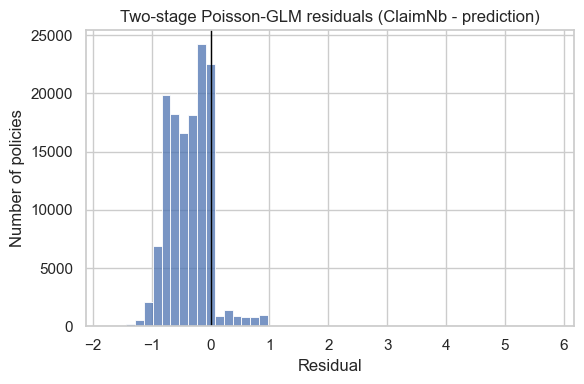

In [1]:
# %%
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_poisson_deviance,
    root_mean_squared_error,
    roc_auc_score,
    average_precision_score,
    make_scorer,
)

from sklearn.linear_model import PoissonRegressor, LogisticRegression
from sklearn.linear_model import TweedieRegressor

sns.set(style="whitegrid")

# %%
# Load prepared data
df = pd.read_csv("../data/claims_prepared.csv")

target_col = "ClaimNb"
exposure_col = "Exposure"
id_col = "IDpol"

df_glm = df.copy()

# VehPower bands (kao u prethodnom GLM notebooku)
df_glm["VehPowerBand"] = pd.cut(
    df_glm["VehPower"],
    bins=[0, 5, 7, 10, 20],
    labels=["<=5", "6-7", "8-10", "11+"],
    right=True,
)

# GLM feature set – čiste, bandovane kategorije + logDensity
glm_features = [
    "Area",
    "VehGas",
    "BonusMalusBand",
    "DrivAgeBand",
    "VehAgeBand",
    "VehPowerBand",
    "Region_lumped",
    "logDensity",
]

X = df_glm[glm_features]
y = df_glm[target_col]
exposure = df_glm[exposure_col]

X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X, y, exposure,
    test_size=0.2,
    random_state=42,
)

X_train.shape, X_test.shape

# %%
# Frequency target (single-stage reference)
y_train_freq = y_train / exp_train
y_test_freq = y_test / exp_test

y_train_freq.describe()

# %%
# Categorical vs numeric za ColumnTransformer
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("GLM categorical features:", cat_features)
print("GLM numeric features:", num_features)

poisson_preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

# =============================================================================
# 1. Single-stage Poisson GLM (baseline za poređenje)
# =============================================================================

# %%
poisson_glm = PoissonRegressor(
    alpha=0.0,
    max_iter=1000,
)

poisson_pipeline = Pipeline(steps=[
    ("preprocess", poisson_preprocess),
    ("model", poisson_glm),
])

poisson_pipeline.fit(
    X_train,
    y_train_freq,
    model__sample_weight=exp_train,
)

print("Single-stage Poisson GLM fitted.")

# %%
# Single-stage predikcija na testu
y_pred_freq_test = poisson_pipeline.predict(X_test)
y_pred_freq_test = np.clip(y_pred_freq_test, 1e-9, None)

y_pred_count_test = y_pred_freq_test * exp_test

poisson_dev_single = mean_poisson_deviance(y_test, y_pred_count_test)
poisson_rmse_single = root_mean_squared_error(y_test, y_pred_count_test)

print(f"Single-stage Poisson GLM Test Poisson deviance: {poisson_dev_single:.4f}")
print(f"Single-stage Poisson GLM Test RMSE:             {poisson_rmse_single:.4f}")

# %%
# Tuning alpha za single-stage Poisson (mali grid)
poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

alpha_grid = np.logspace(-6, -3, 5)  # 1e-6 ... 1e-3

poisson_glm_tuned = PoissonRegressor(max_iter=1000)

poisson_pipeline_tuned = Pipeline(steps=[
    ("preprocess", poisson_preprocess),
    ("model", poisson_glm_tuned),
])

param_grid = {
    "model__alpha": alpha_grid,
}

poisson_search = GridSearchCV(
    estimator=poisson_pipeline_tuned,
    param_grid=param_grid,
    scoring=poisson_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

poisson_search.fit(
    X_train,
    y_train_freq,
    model__sample_weight=exp_train,
)

print("Best single-stage Poisson alpha:", poisson_search.best_params_)
print("Best single-stage CV Poisson dev (freq):", poisson_search.best_score_)

# %%
best_poisson_single = poisson_search.best_estimator_

y_pred_freq_best = best_poisson_single.predict(X_test)
y_pred_freq_best = np.clip(y_pred_freq_best, 1e-9, None)
y_pred_count_best = y_pred_freq_best * exp_test

best_poisson_dev_single = mean_poisson_deviance(y_test, y_pred_count_best)
best_poisson_rmse_single = root_mean_squared_error(y_test, y_pred_count_best)

print(f"Tuned single-stage Poisson Test Poisson deviance: {best_poisson_dev_single:.4f}")
print(f"Tuned single-stage Poisson Test RMSE:             {best_poisson_rmse_single:.4f}")

# =============================================================================
# 2. Two-stage GLM: frequency (logit) * severity (Poisson)
# =============================================================================

# %%
# Stage 1 – Frequency model: P(ClaimNb > 0 | X)
y_train_has = (y_train > 0).astype(int)
y_test_has = (y_test > 0).astype(int)

logit_glm = Pipeline(steps=[
    ("preprocess", poisson_preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",   # retke '1'
    )),
])

logit_glm.fit(
    X_train,
    y_train_has,
    model__sample_weight=exp_train,
)

p_hat_test = logit_glm.predict_proba(X_test)[:, 1]

freq_auc = roc_auc_score(y_test_has, p_hat_test)
freq_ap = average_precision_score(y_test_has, p_hat_test)

print(f"Two-stage GLM – frequency model AUC: {freq_auc:.4f}")
print(f"Two-stage GLM – frequency model AP:  {freq_ap:.4f}")

# %%
# Stage 2 – Severity model: Poisson GLM na polisama sa ClaimNb > 0
mask_pos = y_train > 0

X_train_pos = X_train[mask_pos]
y_train_pos = y_train[mask_pos]
exp_train_pos = exp_train[mask_pos]

print("Train policies:", len(y_train))
print("Train policies with ClaimNb > 0:", len(y_train_pos))
print("Mean ClaimNb among positives:", y_train_pos.mean())

# modelujemo frekvenciju kod claimanata
y_train_pos_freq = y_train_pos / exp_train_pos

poisson_severity = Pipeline(steps=[
    ("preprocess", poisson_preprocess),
    ("model", PoissonRegressor(max_iter=1000)),
])

poisson_severity.fit(
    X_train_pos,
    y_train_pos_freq,
    model__sample_weight=exp_train_pos,
)

print("Two-stage GLM – Poisson severity fitted.")

# %%
# Kombinacija: Y_hat = P(Y>0|X) * E[Y | Y>0, X]
m_hat_freq_test = poisson_severity.predict(X_test)
m_hat_freq_test = np.clip(m_hat_freq_test, 1e-9, None)
m_hat_count_test = m_hat_freq_test * exp_test

y_hat_two_stage_poisson = p_hat_test * m_hat_count_test

two_stage_poisson_dev = mean_poisson_deviance(y_test, y_hat_two_stage_poisson)
two_stage_poisson_rmse = root_mean_squared_error(y_test, y_hat_two_stage_poisson)

print(f"Two-stage Poisson-GLM Test Poisson deviance: {two_stage_poisson_dev:.4f}")
print(f"Two-stage Poisson-GLM Test RMSE:             {two_stage_poisson_rmse:.4f}")

print("\nFor comparison (tuned single-stage Poisson GLM):")
print(f"Single-stage Poisson deviance: {best_poisson_dev_single:.4f}")
print(f"Single-stage Poisson RMSE:     {best_poisson_rmse_single:.4f}")

# =============================================================================
# 3. Two-stage GLM: frequency (logit) * severity (Tweedie)
# =============================================================================

# %%
# Tweedie severity model (na istom subsetu ClaimNb > 0)

tweedie_severity = Pipeline(steps=[
    ("preprocess", poisson_preprocess),
    ("model", TweedieRegressor(
        link="log",
        max_iter=1000,
    )),
])

# Mali RandomizedSearch za power + alpha
from sklearn.model_selection import RandomizedSearchCV

tweedie_param_distributions = {
    "model__power": [1.0, 1.1, 1.2, 1.3, 1.5],          # oko Poissona
    "model__alpha": np.logspace(-6, -2, 5),            # regularizacija
}

tweedie_search = RandomizedSearchCV(
    estimator=tweedie_severity,
    param_distributions=tweedie_param_distributions,
    n_iter=20,
    scoring=poisson_scorer,  # isti scorer kao za Poisson (na frekvenciji)
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

tweedie_search.fit(
    X_train_pos,
    y_train_pos_freq,
    model__sample_weight=exp_train_pos,
)

print("Best Tweedie severity params:", tweedie_search.best_params_)
print("Best Tweedie severity CV Poisson dev (freq):", tweedie_search.best_score_)

# %%
best_tweedie_severity = tweedie_search.best_estimator_

# E[Y | Y>0, X] ~ freq * Exposure (ali koristimo iste X_test, exp_test kao gore)
m_hat_freq_tweedie_test = best_tweedie_severity.predict(X_test)
m_hat_freq_tweedie_test = np.clip(m_hat_freq_tweedie_test, 1e-9, None)
m_hat_count_tweedie_test = m_hat_freq_tweedie_test * exp_test

y_hat_two_stage_tweedie = p_hat_test * m_hat_count_tweedie_test

two_stage_tweedie_dev = mean_poisson_deviance(y_test, y_hat_two_stage_tweedie)
two_stage_tweedie_rmse = root_mean_squared_error(y_test, y_hat_two_stage_tweedie)

print(f"Two-stage Tweedie-GLM Test Poisson deviance: {two_stage_tweedie_dev:.4f}")
print(f"Two-stage Tweedie-GLM Test RMSE:             {two_stage_tweedie_rmse:.4f}")

print("\nSummary:")
print(f"Single-stage Poisson deviance:         {best_poisson_dev_single:.4f}")
print(f"Two-stage Poisson-GLM deviance:        {two_stage_poisson_dev:.4f}")
print(f"Two-stage Tweedie-GLM deviance:        {two_stage_tweedie_dev:.4f}")
print(f"Single-stage Poisson RMSE:             {best_poisson_rmse_single:.4f}")
print(f"Two-stage Poisson-GLM RMSE:            {two_stage_poisson_rmse:.4f}")
print(f"Two-stage Tweedie-GLM RMSE:            {two_stage_tweedie_rmse:.4f}")

# %%
# (Opcionalno) Top 10 grešaka za two-stage Poisson-GLM
errors_two_stage = df_glm.loc[X_test.index, [
    "IDpol",
    "Area",
    "VehGas",
    "BonusMalus",
    "BonusMalusBand",
    "DrivAge",
    "DrivAgeBand",
    "VehAge",
    "VehAgeBand",
    "VehPower",
    "VehPowerBand",
    "Region_lumped",
    "logDensity",
]].copy()

errors_two_stage["ClaimNb"] = y_test
errors_two_stage["Exposure"] = exp_test
errors_two_stage["pred_two_stage_poisson"] = y_hat_two_stage_poisson
errors_two_stage["residual_two_stage_poisson"] = (
    errors_two_stage["ClaimNb"] - errors_two_stage["pred_two_stage_poisson"]
)
errors_two_stage["abs_res_two_stage_poisson"] = errors_two_stage["residual_two_stage_poisson"].abs()

top10_two_stage = (
    errors_two_stage
    .sort_values("abs_res_two_stage_poisson", ascending=False)
    .head(10)
)

display(top10_two_stage)

# %%
# (Opcionalno) distribucija residuala two-stage Poisson-GLM
plt.figure(figsize=(6, 4))
sns.histplot(errors_two_stage["residual_two_stage_poisson"], bins=50, kde=False)
plt.axvline(0, color="black", linewidth=1)
plt.title("Two-stage Poisson-GLM residuals (ClaimNb - prediction)")
plt.xlabel("Residual")
plt.ylabel("Number of policies")
plt.tight_layout()
plt.show()

# %%
